In [15]:
import requests
import polyline

import matplotlib.pyplot as plt
import contextily as ctx

import itertools

import xml.dom.minidom
from xml.etree.ElementTree import Element, SubElement, tostring

In [16]:
DEFAULT_RADIUS_IN_METERS = 5

In [17]:
def osrm_format(coords):
    lat, lon = coords
    return f"{lon},{lat}"

def get_route(points):
    points = ';'.join(map(osrm_format, points))
    params = {
        'geometries': 'polyline6',
    }
    
    response = requests.get(f"http://127.0.0.1:9000/route/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    geometry = routes['routes'][0]['geometry']
    return polyline.decode(geometry, 6)

def get_match(points):
    radiuses = ';'.join([str(DEFAULT_RADIUS_IN_METERS)] * len(points))
    points = ';'.join(map(osrm_format, points))
    
    params = {
        'geometries': 'polyline6',
        'radiuses': radiuses,
    } 
    response = requests.get(f"http://127.0.0.1:9000/match/v1/foot/{points}", params=params)
    routes = response.json()
    
    if routes['code'] != 'Ok':
        print(routes)
        return None
    
    route = [
        polyline.decode(matching['geometry'], 6) 
        if matching['confidence'] > 0.90
        else []
        for matching in routes['matchings']
    ]

    return list(itertools.chain.from_iterable(route))

def plot_gpx(route, ax):
    latitudes = [point[0] for point in route]
    longitudes = [point[1] for point in route]
    ax.plot(longitudes, latitudes, color='red', label='Route')
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    ax.legend()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

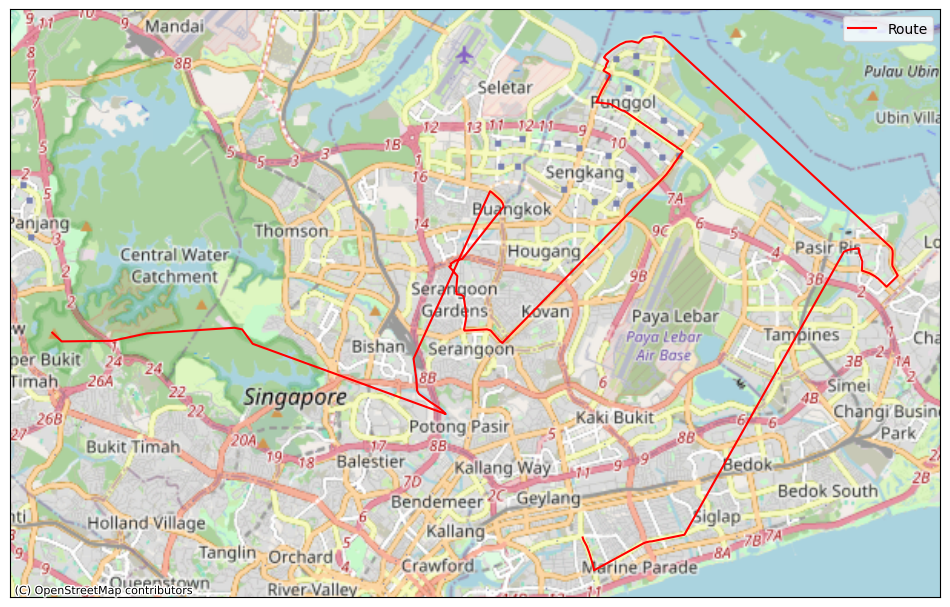

In [19]:
start = (1.3094259512853295, 103.8945520144324)
stop = (1.3551814463295238, 103.77589648110123)

points = [start] + [stop]

osrm_route = get_route(points) 
matched_route = get_match(osrm_route) 

fig, ax = plt.subplots(1, 1, figsize=(12, 30))
plot_gpx(matched_route, ax)
plt.show()